# Title: 

### Group member:
Anyna Wang 53713814

Lindsay Watson

Yiman Ma

## Introduction:

##### background information

##### state the question

##### identify and describe the dataset



## Preliminary exploratory data analysis:

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(tidymodels)
library(digest)
library(repr)
library(ggplot2)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### 1. read data from the web into R and clean the dataset

In [2]:
# The url is a copy link of heart disease data set from UCI Machine Learning Repository website.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"

# Naming each columns based on the information from UCI Machine Learning Repository.
names <- c("age",
           "sex",
           "chest_pain_type",
           "resting_blood_pressure",
           "serum_cholestoral (mg/dl)",
           "fasting_blood_sugar",
           "resting_electrocardiographic_results",
           "maximum_heart_rate",
           "exercise_induced_angina",
           "ST_depression",
           "slope_of_the_peak_exercise_ST_segment",
           "number_of_major_vessels",
           "thal",
           "diagnosis_of_heart_disease")

# Loading processed switzerland heart disease data set
original_switzerland_data <- read_delim(url, delim = ",", col_names = names) |>

                             # making categorie variables as a factor
                             mutate(across(sex : chest_pain_type, as_factor)) |>
                             mutate(across(fasting_blood_sugar : resting_electrocardiographic_results, as_factor)) |>
                             mutate(exercise_induced_angina = as_factor(exercise_induced_angina)) |>
                             mutate(slope_of_the_peak_exercise_ST_segment = as_factor(slope_of_the_peak_exercise_ST_segment)) |>
                             mutate(thal = as_factor(thal)) |>

                             # making age as a integer, because it can't have negative and decimals.
                             mutate(age = as.integer(age)) |>
                    
                             # making number of major vessels as integer, because it has a range with 0-3.
                             mutate(number_of_major_vessels = as.integer(number_of_major_vessels)) |>

                             # making quantitative variables as a double
                             mutate(resting_blood_pressure = as.double(resting_blood_pressure)) |>
                             mutate(maximum_heart_rate = as.double(maximum_heart_rate)) |>
                             mutate(ST_depression = as.double(ST_depression)) 

# If diagnosis of heart disease is 0 
original_switzerland_data$diagnosis_of_heart_disease <- ifelse(original_switzerland_data$diagnosis_of_heart_disease == 0, "false", "true")

# It is impossible to have 0 blood pressure, delate the impossible data. 
# Making diagnosis of heart disease as factor
original_switzerland_data <- original_switzerland_data |>
                             filter(resting_blood_pressure != 0) |>
                             mutate(diagnosis_of_heart_disease = as_factor(diagnosis_of_heart_disease))

# Data can not be "?", replace "?" to NA
original_switzerland_data <- replace(original_switzerland_data , original_switzerland_data == "?", NA)

# First 6 row of the data set
head(original_switzerland_data)

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): resting_blood_pressure, fasting_blood_sugar, resting_electrocardiog...
dbl (5): age, sex, chest_pain_type, serum_cholestoral (mg/dl), diagnosis_of_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral (mg/dl),fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate,exercise_induced_angina,ST_depression,slope_of_the_peak_exercise_ST_segment,number_of_major_vessels,thal,diagnosis_of_heart_disease
<int>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>
32,1,1,95,0,NA,0,127,0,0.7,1,NA,NA,true
34,1,4,115,0,NA,NA,154,0,0.2,1,NA,NA,true
36,1,4,110,0,NA,0,125,1,1.0,2,NA,6,true
38,0,4,105,0,NA,0,166,0,2.8,1,NA,NA,true
38,0,4,110,0,0,0,156,0,0.0,2,NA,3,true
38,1,3,100,0,NA,0,179,0,-1.1,1,NA,NA,false


#### 2. wrangle data set

In [3]:
switzerland_heart_disease_data <- original_switzerland_data |> 
             select(age, resting_blood_pressure, maximum_heart_rate, diagnosis_of_heart_disease)

head(switzerland_heart_disease_data)

age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<dbl>,<dbl>,<fct>
32,95,127,true
34,115,154,true
36,110,125,true
38,105,166,true
38,110,156,true
38,100,179,false


#### 3. summarize data in table

In [4]:
# Making the training data
heart_disease_split <- initial_split(switzerland_heart_disease_data, prop = 0.75, strata = diagnosis_of_heart_disease)
heart_disease_training_data <- training(heart_disease_split)

heart_disease_training_data

age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<dbl>,<dbl>,<fct>
32,95,127,true
34,115,154,true
36,110,125,true
⋮,⋮,⋮,⋮
70,140,157,true
73,160,121,true
74,145,123,true


In [8]:
# Counting rows that have missing data
data_missing_num <- heart_disease_training_data|>
                    map_df(is.na)|>
                    map_df(sum)
data_missing_num

# Counting rows that have data, calculating the mean of age, mean of blood pressure and mean of maximum heart rate
heart_disease_summarize <- heart_disease_training_data|>
                           group_by(diagnosis_of_heart_disease) |>
                           summarize(n_age = sum(!is.na(age)),
                                     n_resting_blood_pressure = sum(!is.na(resting_blood_pressure)),
                                     n_maximum_heart_rate = sum(!is.na(maximum_heart_rate)),
                                     n_diagnosis_of_heart_disease = sum(!is.na(diagnosis_of_heart_disease)),
                                     mean_age = mean(age, na.rm=TRUE),
                                     mean_blood_pressure = mean(resting_blood_pressure, na.rm=TRUE),
                                     mean_heart_rate = mean(maximum_heart_rate, na.rm=TRUE))
heart_disease_summarize

age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<int>,<int>,<int>
0,0,0,0


diagnosis_of_heart_disease,n_age,n_resting_blood_pressure,n_maximum_heart_rate,n_diagnosis_of_heart_disease,mean_age,mean_blood_pressure,mean_heart_rate
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
true,83,83,83,83,55.90361,131.0843,120.4096
false,7,7,7,7,52.14286,119.2857,139.8571


#### 4. visualization data 

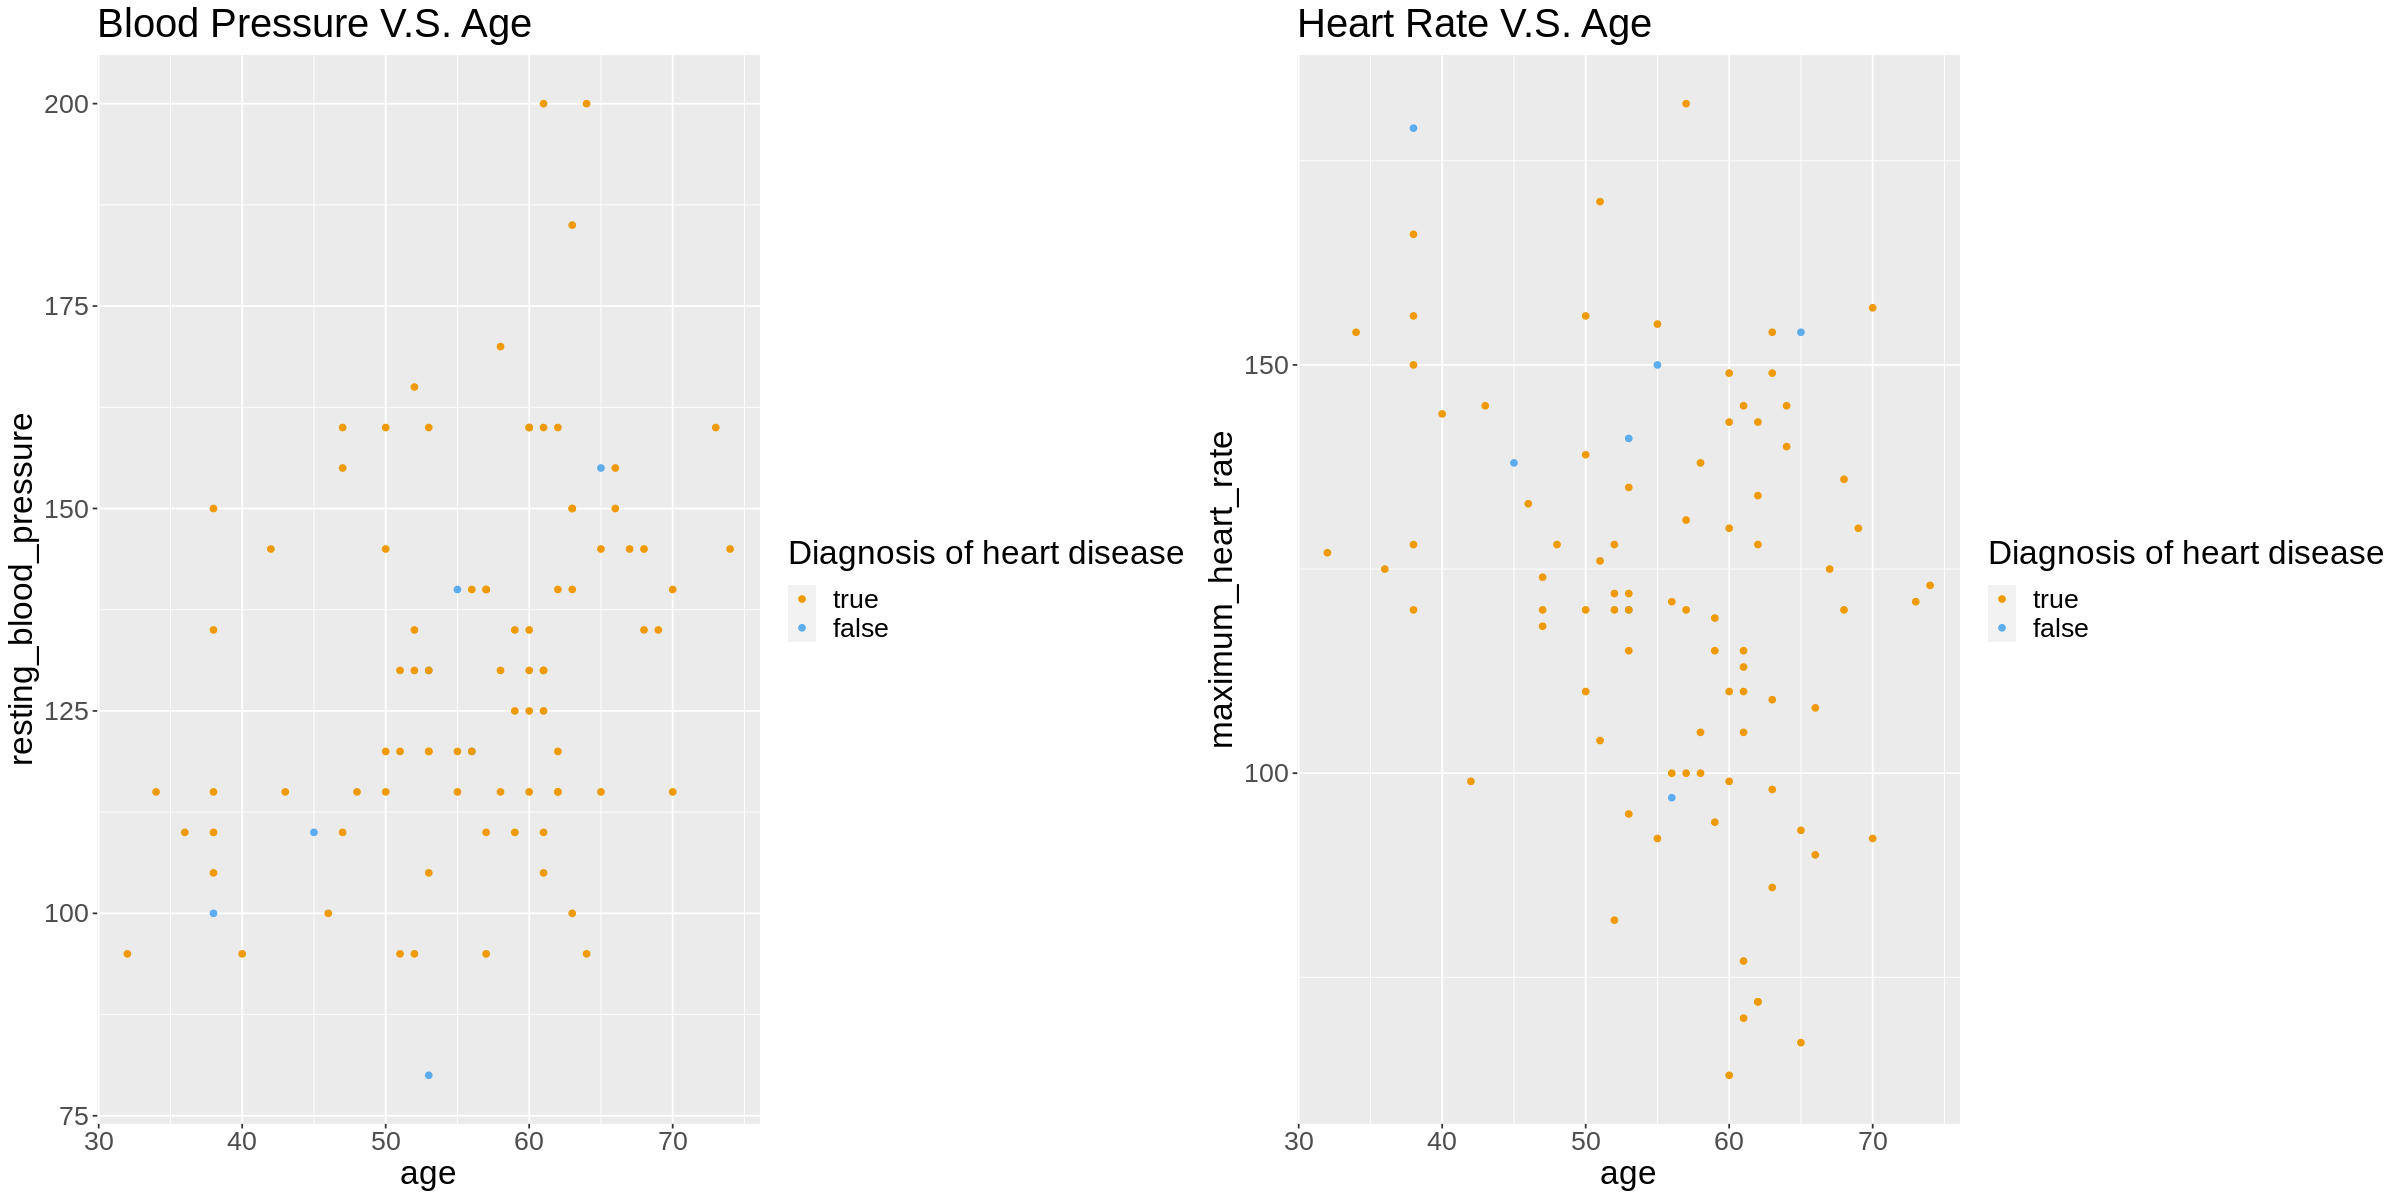

In [17]:
Age_BP <- heart_disease_training_data |>
    ggplot(aes(x = age, y = resting_blood_pressure, color = diagnosis_of_heart_disease)) +
    geom_point(alpha = 5) +
    labs(color = "Diagnosis of heart disease") +
    ggtitle("Blood Pressure V.S. Age")+
    scale_color_manual(labels = c("true", "false"), 
                       values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 20))

Age_HR <- heart_disease_training_data |>
    ggplot(aes(x = age, y = maximum_heart_rate, color = diagnosis_of_heart_disease)) +
    geom_point(alpha = 5) +
    labs(color = "Diagnosis of heart disease") +
    ggtitle("Heart Rate V.S. Age")+
    scale_color_manual(labels = c("true", "false"), 
                       values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 20))

#plot two graphs together
plot_grid(Age_BP, Age_HR)
options(repr.plot.width = 20 ,repr.plot.height = 10)

## Method:

## Expected outcomes and significance:
#### expectation for findings:

#### impact:

#### future questions:

## References: